## NDVI time-series for some regions

We can show how t

## Libraries

In [1]:
import xarray as xr
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import contextily as ctx

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
name='trees'


## Open data

In [3]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

#open original AVHRR
cdr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_NDVI_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
cdr = assign_crs(cdr, crs=crs)
cdr.attrs['nodata'] = np.nan

gimms_pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku = assign_crs(gimms_pku, crs=crs)
gimms_pku.attrs['nodata'] = np.nan

gimms_pku_cons = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku_cons = gimms_pku_cons.sel(time=slice('1982','2013'))
gimms_pku_cons = assign_crs(gimms_pku_cons, crs=crs)
gimms_pku_cons.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

#Open MODIS
modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis = modis.sel(time=slice('1982','2013'))
modis.attrs['nodata'] = np.nan

# #clip time lengths
# merge = merge.sel(time=slice('1982','2000-02'))
# avhrr = avhrr.sel(time=slice('1982','2000-02'))

In [4]:
cdr = cdr.odc.reproject(gimms_pku.odc.geobox, resampling='average')
gimms = gimms.odc.reproject(gimms_pku.odc.geobox, resampling='nearest')
gimms_pku_cons = gimms_pku_cons.odc.reproject(gimms_pku.odc.geobox, resampling='nearest')
modis = modis.odc.reproject(gimms_pku.odc.geobox, resampling='average')

gimms_pku = round_coords(gimms_pku)
gimms_pku_cons = round_coords(gimms_pku_cons)
cdr = round_coords(cdr)
gimms = round_coords(gimms)
modis = round_coords(modis)

In [5]:
gimms_mask =  ~np.isnan(gimms)
del gimms_mask.attrs['nodata']
gimms_mask = assign_crs(gimms_mask, crs=crs)

gimms_mask_cons =  ~np.isnan(gimms_pku_cons)
del gimms_mask_cons.attrs['nodata']
gimms_mask_cons = assign_crs(gimms_mask_cons, crs=crs)

cdr_mask =  ~np.isnan(cdr)
del cdr_mask.attrs['nodata']
cdr_mask = assign_crs(cdr_mask, crs=crs)

pku_mask =  ~np.isnan(gimms_pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

#combine masks
mask = (gimms_mask & cdr_mask & pku_mask & gimms_mask_cons)

In [6]:
gimms_pku = gimms_pku.where(mask)
gimms = gimms.where(mask)
cdr = cdr.where(mask)
gimms_pku_cons = gimms_pku_cons.where(mask)

## Mask areas

In [7]:
#mask for the trees regions
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')
trees = trees.odc.reproject(gimms_pku.odc.geobox, resampling='average')
trees = round_coords(trees)

if name=='trees':
    mask1 = xr.where(trees>0.25, 1, 0)
if name=='nontrees':
    mask1 = xr.where(trees<=0.25, 1, 0)

mask1['longitude'] = cdr.longitude
mask1['latitude'] = cdr.latitude

# #do the masking
cdr = cdr.where(mask1)
gimms = gimms.where(mask1)
gimms_pku = gimms_pku.where(mask1)
gimms_pku_cons = gimms_pku_cons.where(mask1)
modis = modis.where(mask1)

## Create a plot

select a region

In [8]:
# #Tassie
# lat=slice(-39,-45) 
# lon=slice(144,149)
# plotname = 'Tasmania'

#queensland
# lat=slice(-10,-20) 
# lon=slice(140,150)
# plotname='Northern Queensland'

# #SW WA
lat=slice(-31,-36) 
lon=slice(114.5,119)
plotname='Southwest WA'

### Remove outliers

This tidies up the plots

In [9]:
import warnings
warnings.simplefilter('ignore')

def stand_anomalies_filter(ds, lon, lat, sigma=2.5):
    ds = ds.sel(longitude=lon, latitude=lat)
    anoms = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
                )
    outliers = xr.where((anoms> -sigma) & (anoms < sigma), 1, 0)
    return ds.where(outliers)

cdr = stand_anomalies_filter(cdr, lon=lon, lat=lat)
gimms = stand_anomalies_filter(gimms, lon=lon, lat=lat)
gimms_pku= stand_anomalies_filter(gimms_pku, lon=lon, lat=lat)
gimms_pku_cons = stand_anomalies_filter(gimms_pku_cons, lon=lon, lat=lat)

In [10]:
roll=12

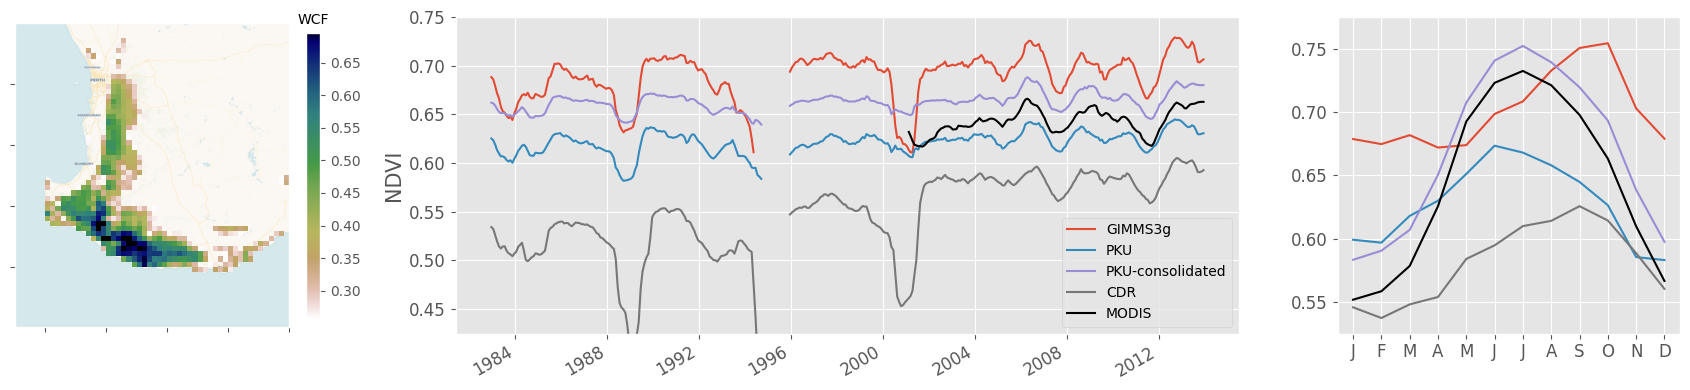

In [12]:
mosiac = [
    ["A", "B", "B", "C"],
]

fig, ax = plt.subplot_mosaic(mosiac, figsize=(17,4))

im = trees.where(trees>0.25).sel(longitude=lon, latitude=lat).plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 
cbar = plt.colorbar(im, ax=ax['A'], shrink=0.9)
cbar.ax.set_title('WCF', fontsize=10)
ax['A'].set_yticklabels([])
ax['A'].set_xticklabels([])
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

ax["B"].grid(True)
gimms.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax["B"], label='GIMMS3g')
gimms_pku.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax["B"], label='PKU')
gimms_pku_cons.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax["B"], label='PKU-consolidated')
cdr.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax["B"], label='CDR')
modis.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax["B"], label='MODIS', color='black')
ax["B"].legend(fontsize=10, loc='lower right')
ax["B"].set_title(None)
ax["B"].set_ylabel('NDVI', fontsize=15)
ax["B"].set_xlabel(None)
ax["B"].set_ylim(0.425, 0.75)
ax['B'].tick_params(axis='y', labelsize=12)
ax['B'].tick_params(axis='x', labelsize=12)

gimms.sel(longitude=lon, latitude=lat).sel(time=slice('2000','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='GIMMS3g')
gimms_pku.sel(longitude=lon, latitude=lat).sel(time=slice('2000','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='PKU')
gimms_pku_cons.sel(longitude=lon, latitude=lat).sel(time=slice('2000','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='PKU-consolidated')
cdr.sel(longitude=lon, latitude=lat).sel(time=slice('2000','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='CDR')
modis.sel(longitude=lon, latitude=lat).sel(time=slice('2000','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='MODIS', color='black')
# 
# ax["C"].legend(fontsize=10)
ax["C"].set_title(None)
# ax["C"].set_ylabel('NDVI', fontsize=15)
ax["C"].set_xlabel(None)
ax["C"].set_ylim(0.525, 0.775)
ax['C'].tick_params(axis='y', labelsize=12)
ax["C"].set_xticks(range(1,13))
ax["C"].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],fontsize=12)

plt.tight_layout();
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/WA_compare_NDVI_timeseries.png",
            bbox_inches='tight', dpi=300);